# AUTOMATIC TICKET CLASSIFICATION

### Aim : To create a model that can automatically classify customer complaints based on the products and services mentioned in the ticket.

## Problem Statement 

- For a financial company, __customer complaints__ carry a lot of importance, as they are often an indicator of the __shortcomings in their products and services__. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.<br><br>
- These customer complaints are __unstructured text data__; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.<br><br>
- Thus we have to automate this __customer support tickets system__.<br>

## Business Goal

- We need to build a model that is able to __classify customer complaints based on the products/services__. By doing so, we can __segregate__ these tickets into their __relevant categories__ and, therefore, help in the __quick resolution of the issue__.<br><br>
- With the help of __non-negative matrix factorization (NMF)__, an approach under __topic modelling__, we will detect __patterns and recurring words__ present in each ticket. This can be then used to understand the __important features__ for each cluster of categories. By __segregating the clusters__, we will be able to identify the __topics of the customer complaints__. <br><br>

- We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is __not labelled__, we need to apply __NMF__ to __analyse patterns and classify tickets__ into the following __five clusters__ based on their products/services:

> - Credit card / Prepaid card
> - Bank account services
> - Theft/Dispute reporting
> - Mortgages/loans
> - Others <br>


- With the help of __topic modelling__, we will be able to __map each ticket onto its respective department/category__. We can then use this data to train any supervised model such as __logistic regression, decision tree or random forest__. Using this trained model, we can __classify__ any new customer complaint support __ticket__ into its __relevant department__.

## Pipelines that needs to be performed:


1. Loading data

2. Data understanding

3. Data preparation

4. Prepare the text for topic modeling

5. Exploratory Data Analysis (EDA)

6. Feature extraction 

7. Topic modeling using NMF

8. Supervised Model to predict any new complaints to relevant topics
> a. Logistic Regression<br>
> b. Decision Tree Classifier<br>
> c. Random Forest Classifier<br>
> d. NAive Bayes<br>

9. Model inference

## Import the required libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from pprint import pprint
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gayth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gayth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. LOADING DATA

The data is in __JSON format__ and we need to convert it to a __dataframe__.

In [3]:
# Opening JSON file 

f = open('complaints-2021-05-14_08_16.json','r')
  
# Load the file returning JSON object as a dictionary 

data = json.load(f)

# Convert the dictionary into a dataframe

df=pd.json_normalize(data)

## 2. DATA UNDERSTANDING

In [4]:
# First 5 records of the dataframe

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# Shape of the dataframe

df.shape

(78313, 22)

In [6]:
# Inspect the dataframe to understand the given data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

### Initial analysis of data  :
- Number of records : __78313__
- Number of columns : __22__
- __21 columns__ are of __'object'__ type and __1__ with the __'float'__ type
- The columns __'_source.tags', '_source.zip_code', '_source.state', '_source.company_public_response', '_source.sub_product', '_source.sub_issue', '_source.consumer_consent_provided'__ have null values while other columns doesn't have any null values.

## 3. DATA PREPARATION

In [7]:
# Columns in the dataframe

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
# Customer complaints are stored in the column '_source.complaint_what_happened'

df['_source.complaint_what_happened']

0                                                         
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                         
4                                                         
                               ...                        
78308                                                     
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: _source.complaint_what_happened, Length: 78313, dtype: object

In [9]:
# Lets rename the columns for readability purpose

new_cols = []

for col in df.columns:
    new_column = re.sub('_source.','',col)           
    if(new_column[0] == '_'):
        new_column = new_column[1:]
    new_cols.append(new_column.title())
    
df.columns = new_cols

print("New columns of the dataframe after renaming : \n\n",df.columns.to_list())

New columns of the dataframe after renaming : 

 ['Index', 'Type', 'Id', 'Score', 'Tags', 'Zip_Code', 'Complaint_Id', 'Issue', 'Date_Received', 'State', 'Consumer_Disputed', 'Product', 'Company_Response', 'Company', 'Submitted_Via', 'Date_Sent_To_Company', 'Company_Public_Response', 'Sub_Product', 'Timely', 'Complaint_What_Happened', 'Sub_Issue', 'Consumer_Consent_Provided']


In [10]:
# Checking counts of null values for each column 

df.isnull().sum()

Index                            0
Type                             0
Id                               0
Score                            0
Tags                         67413
Zip_Code                      6757
Complaint_Id                     0
Issue                            0
Date_Received                    0
State                         1991
Consumer_Disputed                0
Product                          0
Company_Response                 0
Company                          0
Submitted_Via                    0
Date_Sent_To_Company             0
Company_Public_Response      78309
Sub_Product                  10571
Timely                           0
Complaint_What_Happened          0
Sub_Issue                    46297
Consumer_Consent_Provided     1008
dtype: int64

In [11]:
# Replacing null values with "NAN" in 'Complaint_What_Happened' column

df['Complaint_What_Happened'] = df['Complaint_What_Happened'].replace('',"NAN")

In [12]:
# Lets check for the non-null records of the 'Complaint_What_Happened' column

df[df['Complaint_What_Happened']!= 'NAN'].shape

(21072, 22)

In [13]:
# Lets check for the null records of the 'Complaint_What_Happened' column

df[df['Complaint_What_Happened']== 'NAN'].shape

(57241, 22)

In [14]:
# Since 57241 records doesnot contain any info regarding complaints, lets remove them from analysis
# Include only the records which has non-null values in 'Complaint_What_Happened' column

df = df[df['Complaint_What_Happened']!= 'NAN'].reset_index()
df = df.drop("index", axis = 1)

In [15]:
# Lets now check the shape of the dataframe

df.shape

(21072, 22)

In [16]:
print("Percentage of data considered for analysis from the original file : ",round(((21072/78313)*100),2))

Percentage of data considered for analysis from the original file :  26.91


In [17]:
# Information of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      21072 non-null  object 
 1   Type                       21072 non-null  object 
 2   Id                         21072 non-null  object 
 3   Score                      21072 non-null  float64
 4   Tags                       3816 non-null   object 
 5   Zip_Code                   16427 non-null  object 
 6   Complaint_Id               21072 non-null  object 
 7   Issue                      21072 non-null  object 
 8   Date_Received              21072 non-null  object 
 9   State                      20929 non-null  object 
 10  Consumer_Disputed          21072 non-null  object 
 11  Product                    21072 non-null  object 
 12  Company_Response           21072 non-null  object 
 13  Company                    21072 non-null  obj

In [18]:
# Head of the dataframe after removing empty complaint records

df.head()

,Index,Type,Id,Score,Tags,Zip_Code,Complaint_Id,Issue,Date_Received,State,...,Company_Response,Company,Submitted_Via,Date_Sent_To_Company,Company_Public_Response,Sub_Product,Timely,Complaint_What_Happened,Sub_Issue,Consumer_Consent_Provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## 4. PREPARE THE TEXT FOR TOPIC MODELING 

Once we have removed all the blank complaints, we need to:

* __Make the text lowercase__
* __Remove text in square brackets__
* __Remove punctuation__
* __Remove words containing numbers__


Once we have done these cleaning operations we need to perform the following:

* __Lemmatize the texts__
* __Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"]__


In [19]:
# Function to clean the text and remove all the unnecessary elements

def clean_text(complaint_data):
    
    # Remove new line \n
    complaint_data = re.sub(r'[\n]+', '',complaint_data)
    
    # Make the text lower case
    complaint_data = complaint_data.lower()
    
    # Remove text in square brackets
    complaint_data = re.sub(r'\[\s*.*?\s*\]', '',complaint_data)
    
    # Remove words containing numbers
    complaint_data = re.sub(r'[a-zA-Z]+\d+\w*|\d+[a-zA-Z]+\w*', '',complaint_data)
    
    # Remove punctuation
    complaint_data = re.sub(r'[!,:;\'"`?\-_{}\(\)\\/]+', '',complaint_data)
    
    # Remove '.' only at the end of sentences 
    # For example, '.' in '1000.00' has a meaning unlike the normal period(.)
    # So it is important to retain this meaning in the input text
    
    complaint_data = re.sub(r'(\.+\s)+', ' ',complaint_data)
    
    complaint_data = re.sub(r'[.]$', '',complaint_data)   
    
    return complaint_data
    

In [20]:
# Clean the text present in the 'Complaint_What_Happened' column and store the cleaned text in the 'Complaints' column

df['Cleaned_Complaint_Text'] = df.swifter.apply(lambda x : clean_text(x['Complaint_What_Happened']), axis = 1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [21]:
# Sample of uncleaned and cleaned text

print("Uncleaned Text : \n",df['Complaint_What_Happened'][147])
print("\nCleaned Text : \n",df['Cleaned_Complaint_Text'][147])

Uncleaned Text : 
 I was a victim of online fraud. I reported an unauthorized purchase for {$3300.00} on XX/XX/19 through XXXX to Chase Bank because the money was taken from my debit card account. I have messages of me asking the seller to cancel the order, the seller never answered back and sent me an empty package. I filled up a police report. I sent the police report, pictures of the package ( I also have a video of me opening the package ) and screenshots of the messages to Chase bank. However, they refused to give me that refund because they said that they had " evidence, '' I asked them to send it to me. I received a letter and the evidence they found was the tracking number. I had the tracking number from the beginning, but that is not evidence of anything. I did not purchase that computer on XXXX, and I also received an empty package. The pseudo company of XXXX is called " XXXX. '' Someone signed for that package, and it was not me or someone I know. The address they wrote was 

In [22]:
# Function to Lemmatize the texts

def lemmatize_text(complaint_data):
    
    tokens = word_tokenize(complaint_data)
    wordnet_lemmatizer = WordNetLemmatizer()
    complaint_lemma = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    complaint_lemma_str = " ".join(complaint_lemma)
    
    return complaint_lemma_str

In [23]:
# Lemmatize the cleaned data using 'lemmatize_text' function
    
df['Lemmatized_Complaint'] = df.swifter.apply(lambda x: lemmatize_text(x['Cleaned_Complaint_Text']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [24]:
# Sample of cleaned text and its lemma

print("Cleaned Text : \n", df['Cleaned_Complaint_Text'][140])
print("\nLemmatized Text : \n", df['Lemmatized_Complaint'][140])

Cleaned Text : 
 i purchased a refrigerator on a store credit card i mistakenly decided that i would use my ability to use cash advance to pay off another credit card to transfer the store card balance to my chase mc that offered no interest for 12 months i payed the xxxx  process  fee i should have had a red flag then i have paid on my balance for 6 months now and have no discernable difference in the balance of the transferred to 0 percent apr balance i called them about this and i have never had such a go around the bush explanation for why this is happening once xxxx get s here ill be paying major interest on this purchase more than if i had left it on the store card this is a sham of a way to get you in a spiral upward issue with interest on one s credit card i am at this point just going to pay all but xxxx of the balance and be done with this completely by xxxx and not use the chase card again even for my amazon xxxx unless i can pay off within the month i certainly will never u

In [25]:
# Creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame({'Cleaned_Complaint_Text' : df['Cleaned_Complaint_Text'], 
                         'Lemmatized_Complaint' : df['Lemmatized_Complaint'] })
df_clean

,Cleaned_Complaint_Text,Lemmatized_Complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,i upgraded my xxxx xxxx card in xxxx2018 and w...
2,chase card was reported on xxxx2019 however fr...,chase card wa reported on xxxx2019 however fra...
3,on xxxx2018 while trying to book a xxxx xxxx ...,on xxxx2018 while trying to book a xxxx xxxx t...
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...
...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...


In [26]:
# Function to extract the POS tags 

def pos_tag(text):
    
    lemma_text = []
    tokens = nlp(text)
    for token in tokens:
        if(token.tag_ == 'NN'):
            lemma_text.append(token.lemma_)
    lemma_text_str = " ".join(lemma_text)
    
    return lemma_text_str

In [27]:
# 'Complaint_POS_removed' column contains lemmatized text with all the words removed having tags other than NN[tag == "NN"]

df_clean["Complaint_POS_removed"] = df_clean.swifter.apply(lambda x: pos_tag(x['Lemmatized_Complaint']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [28]:
# 'df_clean' dataframe now contains the cleaned complaints, lemmatized complaints and the complaints after removing POS tags

df_clean

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop service debt verification st...
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,i upgraded my xxxx xxxx card in xxxx2018 and w...,agent anniversary date agent information order...
2,chase card was reported on xxxx2019 however fr...,chase card wa reported on xxxx2019 however fra...,chase card application identity consent servic...
3,on xxxx2018 while trying to book a xxxx xxxx ...,on xxxx2018 while trying to book a xxxx xxxx t...,ticket offer ticket reward card information of...
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...
...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim purchase protection...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...


## 5. EXPLORATORY DATA ANALYSIS (EDA)

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text

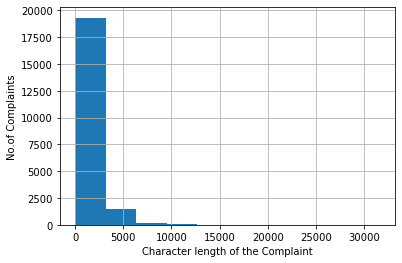

In [29]:
# Lets visualise the data according to the 'Complaint' character length

df['Complaint_What_Happened'].str.len().hist()

plt.xlabel("Character length of the Complaint")
plt.ylabel("No.of Complaints")

plt.show()

#### Inference : 
- It is evident that most of the complaints have character length of around 2700 to 3000 and a few complaints have character length of around 3000 to 6000.

<Figure size 432x288 with 0 Axes>

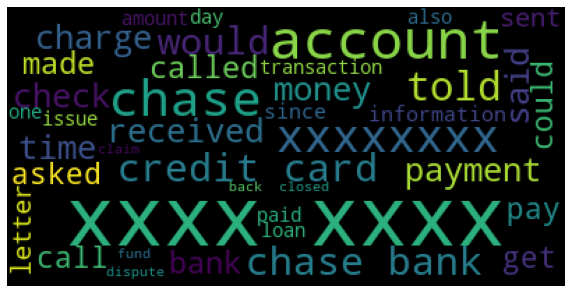

In [30]:
# Using a word cloud to find the top 40 words by frequency among all the articles after processing the text

stops = set(stopwords.words('english'))
wc = WordCloud(stopwords =stops , max_words=40).generate(' '.join(df['Cleaned_Complaint_Text']))
fig = plt.figure(1)
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [31]:
# Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['Complaint_POS_removed'].str.replace('-PRON-', '')

#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis.

In [32]:
df['Cleaned_Complaint_Text'] = df['Cleaned_Complaint_Text'].str.replace('xx+', '',regex=True)

for col in df_clean.columns:
    df_clean[col] = df_clean[col].str.replace('xx+','',regex=True)

<Figure size 432x288 with 0 Axes>

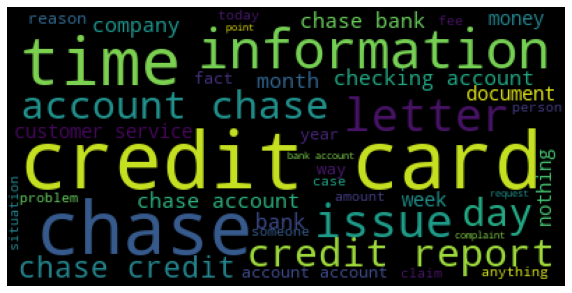

In [33]:
# Now lets use word cloud to find the top 40 words by frequency among all the articles after removing masked text

stops = set(stopwords.words('english'))
wc = WordCloud(stopwords =stops , max_words=40).generate(' '.join(df_clean['Complaint_clean']))
fig = plt.figure(1)
plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text

In [34]:
# Function to find the n-gram frequency among the complaints in the cleaned datafram(df_clean)

def n_gram_freq(n):
    stops = set(stopwords.words('english'))
    corpus = df_clean['Complaint_clean']
    vec = CountVectorizer(stop_words=stops, ngram_range=(n,n)).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [35]:
# Top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean)

words_freq_uni = n_gram_freq(1)
words_freq_uni[:30]

[('chase', 62179),
 ('account', 46233),
 ('credit', 32208),
 ('card', 29912),
 ('payment', 21091),
 ('bank', 17992),
 ('time', 16015),
 ('day', 12865),
 ('charge', 11963),
 ('money', 11957),
 ('loan', 10796),
 ('check', 10148),
 ('information', 9635),
 ('letter', 9582),
 ('fee', 8872),
 ('number', 8597),
 ('transaction', 8497),
 ('month', 8452),
 ('amount', 8337),
 ('year', 8223),
 ('customer', 8043),
 ('mortgage', 7939),
 ('balance', 7697),
 ('company', 7510),
 ('phone', 7485),
 ('service', 7338),
 ('report', 6893),
 ('fund', 6863),
 ('claim', 6687),
 ('fraud', 6633)]

In [36]:
# Top 10 words in the unigram frequency

print("\nTop 10 words in the unigram frequency : \n\n", words_freq_uni[:10])


Top 10 words in the unigram frequency : 

 [('chase', 62179), ('account', 46233), ('credit', 32208), ('card', 29912), ('payment', 21091), ('bank', 17992), ('time', 16015), ('day', 12865), ('charge', 11963), ('money', 11957)]


In [37]:
# Create a dataframe for unigram words

unigram_words_df = pd.DataFrame(words_freq_uni, columns =['Unigram Words', 'Frequency'])
unigram_words_df = unigram_words_df.set_index('Unigram Words')

unigram_words_df.head()

,Frequency
Unigram Words,
chase,62179
account,46233
credit,32208
card,29912
payment,21091


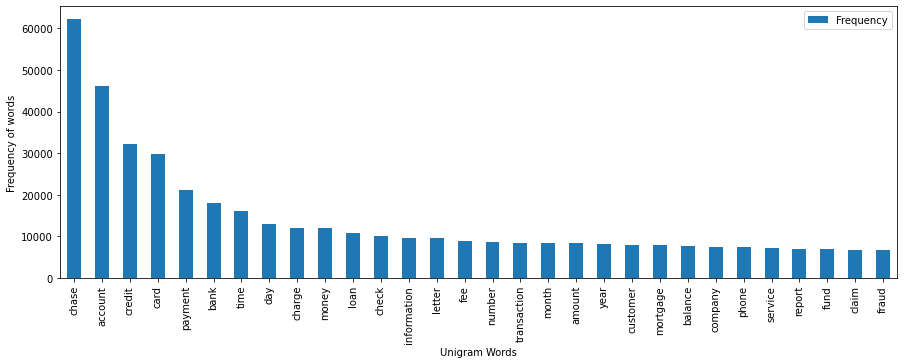

In [38]:
# Lets visualise the bar plot of top 30 unigram words

unigram_words_df[:30].plot(kind='bar', xlabel= "Unigram Words", ylabel= "Frequency of words", figsize=(15,5), fontsize=10)
plt.show()

In [39]:
# Top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean)

words_freq_bi = n_gram_freq(2)
words_freq_bi[:30]

[('credit card', 12605),
 ('credit report', 3794),
 ('account chase', 3626),
 ('chase credit', 3552),
 ('checking account', 3406),
 ('chase bank', 3020),
 ('chase account', 2990),
 ('customer service', 2955),
 ('account account', 2575),
 ('bank account', 2201),
 ('debit card', 1992),
 ('card chase', 1966),
 ('chase card', 1855),
 ('credit score', 1710),
 ('card account', 1696),
 ('phone call', 1630),
 ('payment payment', 1557),
 ('account credit', 1529),
 ('chase chase', 1449),
 ('money account', 1402),
 ('letter chase', 1364),
 ('chase customer', 1332),
 ('interest rate', 1295),
 ('phone number', 1248),
 ('payment chase', 1223),
 ('business day', 1206),
 ('card card', 1198),
 ('account number', 1174),
 ('credit bureau', 1164),
 ('card company', 1132)]

In [40]:
# Top 10 words in the bigram frequency

print("\nTop 10 words in the bigram frequency : \n\n", words_freq_bi[:10])


Top 10 words in the bigram frequency : 

 [('credit card', 12605), ('credit report', 3794), ('account chase', 3626), ('chase credit', 3552), ('checking account', 3406), ('chase bank', 3020), ('chase account', 2990), ('customer service', 2955), ('account account', 2575), ('bank account', 2201)]


In [41]:
# Create a dataframe for bigram words

bigram_words_df = pd.DataFrame(words_freq_bi, columns =['Bigram Words occuring together', 'Frequency of words'])
bigram_words_df = bigram_words_df.set_index('Bigram Words occuring together')

bigram_words_df.head()

,Frequency of words
Bigram Words occuring together,
credit card,12605
credit report,3794
account chase,3626
chase credit,3552
checking account,3406


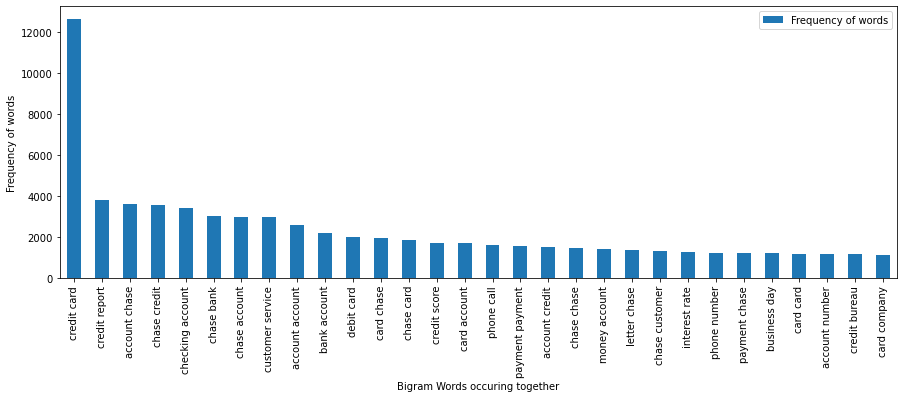

In [42]:
# Lets visualise the bar plot of top 30 bigram words

bigram_words_df[:30].plot(kind='bar', xlabel= "Bigram Words occuring together", ylabel= "Frequency of words", 
                          figsize=(15,5), fontsize=10)
plt.show()

In [43]:
# Top 30 trigram frequency among the complaints in the cleaned dataframe(df_clean)

words_freq_tri = n_gram_freq(3)
words_freq_tri[:30]

[('chase credit card', 2440),
 ('credit card account', 1051),
 ('credit card company', 986),
 ('credit card chase', 869),
 ('chase customer service', 590),
 ('credit card credit', 544),
 ('inquiry credit report', 541),
 ('chase checking account', 512),
 ('card credit card', 436),
 ('account credit card', 430),
 ('checking account chase', 399),
 ('charge credit card', 364),
 ('credit report credit', 363),
 ('customer service representative', 341),
 ('account chase account', 333),
 ('credit reporting act', 328),
 ('chase bank account', 324),
 ('account credit report', 324),
 ('credit card payment', 319),
 ('credit report chase', 273),
 ('credit card card', 272),
 ('credit card balance', 272),
 ('chase auto finance', 266),
 ('chase card service', 257),
 ('victim identity theft', 252),
 ('payment credit card', 242),
 ('chase account chase', 241),
 ('credit card charge', 239),
 ('phone call chase', 235),
 ('freedom credit card', 229)]

In [44]:
# Top 10 words in the trigram frequency

print("\nTop 10 words in the trigram frequency : \n\n", words_freq_tri[:10])


Top 10 words in the trigram frequency : 

 [('chase credit card', 2440), ('credit card account', 1051), ('credit card company', 986), ('credit card chase', 869), ('chase customer service', 590), ('credit card credit', 544), ('inquiry credit report', 541), ('chase checking account', 512), ('card credit card', 436), ('account credit card', 430)]


In [45]:
# Create a dataframe for trigram words

trigram_words_df = pd.DataFrame(words_freq_tri, columns =['Trigram Words occuring together', 'Frequency of words'])
trigram_words_df = trigram_words_df.set_index('Trigram Words occuring together')

trigram_words_df.head()

,Frequency of words
Trigram Words occuring together,
chase credit card,2440
credit card account,1051
credit card company,986
credit card chase,869
chase customer service,590


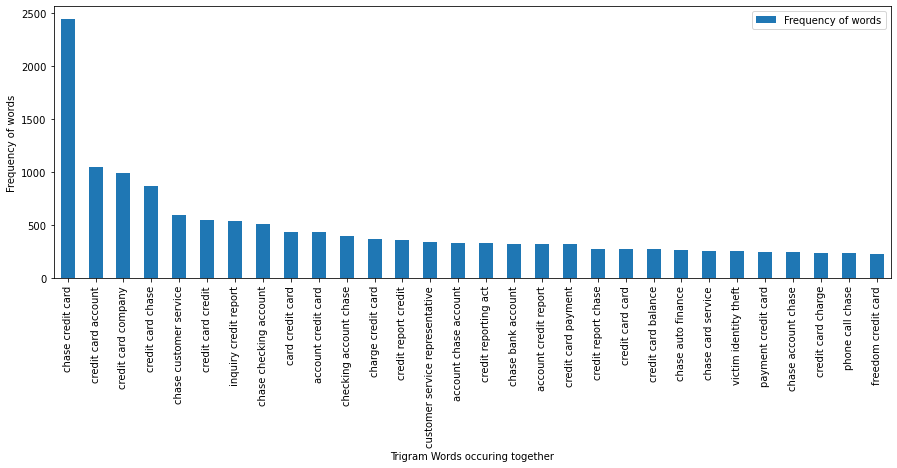

In [46]:
# Lets visualise the bar plot of top 30 trigram words

trigram_words_df[:30].plot(kind='bar', xlabel= "Trigram Words occuring together", ylabel= "Frequency of words", 
                          figsize=(15,5), fontsize=10)
plt.show()

In [47]:
# All masked texts has been removed

df_clean

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it ...,good morning my name is and i appreciate it ...,morning name stop service debt verification st...,morning name stop service debt verification st...
1,i upgraded my card in 2018 and was told by t...,i upgraded my card in 2018 and wa told by th...,agent anniversary date agent information order...,agent anniversary date agent information order...
2,chase card was reported on 2019 however fraudu...,chase card wa reported on 2019 however fraudul...,chase card application identity consent servic...,chase card application identity consent servic...
3,on 2018 while trying to book a ticket i ca...,on 2018 while trying to book a ticket i came...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday i called chas my visa credit c...,on wednesday i called chas my visa credit c...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
21069,i am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## 6. FEATURE EXTRACTION
Convert the raw texts to a __matrix of TF-IDF features__

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [48]:
# Code to initialise the TF-IDF Vectorizer 

tfidf_vectorizer = TfidfVectorizer(
    stop_words = 'english',
    min_df = 2,
    max_df = 0.95,
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0.

In [49]:
# Code to create the Document Term Matrix by transforming the 'Complaint_clean' column present in df_clean

tfidf = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])
features = tfidf_vectorizer.get_feature_names()

# Creating a dataframe to display the document-term matrix

tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

,10,1099misc,10day,11,12,14,15,15year,16,17,...,yield,yoga,youth,yr,ytd,zilch,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Shape of the tfidf_df dataframe 

tfidf_df.shape

(21072, 6042)

## 7. TOPIC MODELING USING NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) __high-dimensional vectors__ into a __lower-dimensional representation__. These lower-dimensional vectors are __non-negative__ which also means their coefficients are __non-negative__.

In this task you have to perform the following:

* __Find the best number of clusters__
* __Apply the best number to create word clusters__
* __Inspect & validate the correction of each cluster wrt the complaints__
* __Correct the labels if needed__ 
* __Map the clusters to topics/cluster names__

## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for our NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [51]:
# Load nmf_model with n_components = 5

num_topics = 5

# Keeping the random_state = 40

nmf_model = NMF(random_state=40, n_components=num_topics)

In [52]:
# Fit the nmf model

nmf_model.fit(tfidf)
H = nmf_model.components_  

# Number of features extracted

len(tfidf_vectorizer.get_feature_names())

6042

In [53]:
# Function to print the top 'n' words for each of the topics

def print_top_n_words(n):

    words = np.array(tfidf_vectorizer.get_feature_names())
    topic_words = pd.DataFrame(np.zeros((num_topics, n)), index=[f'Topic {i}' for i in range(num_topics)],
                               columns=[f'Word {i + 1}' for i in range(n)]).astype(str)
    for i in range(num_topics):
        ix = H[i].argsort()[::-1][:n]
        topic_words.iloc[i] = words[ix]

    return topic_words

In [54]:
# lets see the top 15 words for each of the topics

topic_words_15 = print_top_n_words(15)
print("Top 15 words for each of the topics : \n\n", topic_words_15.T)

Top 15 words for each of the topics : 

              Topic 0      Topic 1    Topic 2      Topic 3       Topic 4
Word 1       account         card    payment       credit          loan
Word 2         check       charge    balance       report      mortgage
Word 3          bank        chase        fee      inquiry         chase
Word 4         money       credit      month         card          home
Word 5         chase      dispute  statement      account  modification
Word 6          fund     purchase        day        score      property
Word 7      checking  transaction       time       bureau          year
Word 8           day        fraud     credit      company        letter
Word 9       deposit      service      chase         debt          time
Word 10       branch     merchant       date  information      document
Word 11  transaction         time       auto    reporting          rate
Word 12       number          fee       year     identity   foreclosure
Word 13          fee   

In [55]:
# For more clarity lets see the top 30 words for each of the topics

topic_words_30 = print_top_n_words(30)
print("Top 30 words for each of the topics : \n\n", topic_words_30.T)

Top 30 words for each of the topics : 

              Topic 0         Topic 1         Topic 2        Topic 3  \
Word 1       account            card         payment         credit   
Word 2         check          charge         balance         report   
Word 3          bank           chase             fee        inquiry   
Word 4         money          credit           month           card   
Word 5         chase         dispute       statement        account   
Word 6          fund        purchase             day          score   
Word 7      checking     transaction            time         bureau   
Word 8           day           fraud          credit        company   
Word 9       deposit         service           chase           debt   
Word 10       branch        merchant            date    information   
Word 11  transaction            time            auto      reporting   
Word 12       number             fee            year       identity   
Word 13          fee         balance

In [56]:
# Create the best topic for each complaint in terms of integer values 0,1,2,3 & 4

best_topic = nmf_model.transform(tfidf)
print("The best topic assigned for each complaint in terms of integer values 0,1,2,3 & 4 : \n",best_topic.argmax(axis=1))

The best topic assigned for each complaint in terms of integer values 0,1,2,3 & 4 : 
 [4 0 1 ... 3 2 2]


In [57]:
# Assign the best topic to each of the complaints in Topic Column

df_clean['Topic_Numbers'] = best_topic.argmax(axis=1)

In [58]:
# Head of the df_clean dataframe

df_clean.head()

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed,Complaint_clean,Topic_Numbers
0,good morning my name is and i appreciate it ...,good morning my name is and i appreciate it ...,morning name stop service debt verification st...,morning name stop service debt verification st...,4
1,i upgraded my card in 2018 and was told by t...,i upgraded my card in 2018 and wa told by th...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
2,chase card was reported on 2019 however fraudu...,chase card wa reported on 2019 however fraudul...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,on 2018 while trying to book a ticket i ca...,on 2018 while trying to book a ticket i came...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0


In [59]:
# Print the first 5 Complaints for each of the Topics

top5_df = df_clean.groupby('Topic_Numbers').head(5)
top5_df.sort_values('Topic_Numbers')

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed,Complaint_clean,Topic_Numbers
12,i opened an account with chase bank on and us...,i opened an account with chase bank on and us...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
1,i upgraded my card in 2018 and was told by t...,i upgraded my card in 2018 and wa told by th...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0
6,with out notice j.p morgan chase restricted my...,with out notice j.p morgan chase restricted my...,chase account debit card branch customer servi...,chase account debit card branch customer servi...,0
10,mishandling of this account by chase auto and,mishandling of this account by chase auto and,account chase auto,account chase auto,0
2,chase card was reported on 2019 however fraudu...,chase card wa reported on 2019 however fraudul...,chase card application identity consent servic...,chase card application identity consent servic...,1
19,i made a purchase with on 2019 in the amoun...,i made a purchase with on 2019 in the amoun...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
8,on 2019 i made a $300.00 payment to an online...,on 2019 i made a $ 300.00 payment to an onlin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
16,a sofa love seat table and chairs and was ne...,a sofa love seat table and chair and wa neve...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1
14,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1


In [60]:
# Lets check how many complaints does each topic contains

df_clean['Topic_Numbers'].value_counts()

1    6098
0    5830
4    3920
3    2692
2    2532
Name: Topic_Numbers, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [61]:
# Create the dictionary of Topic names and Topics

Topic_names =   {
                0 : "Bank account services",
                1 : "Theft/Dispute reporting",
                2 : "Others",
                3 : "Credit Card/Prepaid Card",
                4 : "Mortgages/loans"
                }

# Map the topic numbers to Topic Names

df_clean['Topic_Names'] = df_clean['Topic_Numbers'].map(Topic_names)

In [62]:
df_clean

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed,Complaint_clean,Topic_Numbers,Topic_Names
0,good morning my name is and i appreciate it ...,good morning my name is and i appreciate it ...,morning name stop service debt verification st...,morning name stop service debt verification st...,4,Mortgages/loans
1,i upgraded my card in 2018 and was told by t...,i upgraded my card in 2018 and wa told by th...,agent anniversary date agent information order...,agent anniversary date agent information order...,0,Bank account services
2,chase card was reported on 2019 however fraudu...,chase card wa reported on 2019 however fraudul...,chase card application identity consent servic...,chase card application identity consent servic...,1,Theft/Dispute reporting
3,on 2018 while trying to book a ticket i ca...,on 2018 while trying to book a ticket i came...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3,Credit Card/Prepaid Card
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,0,Bank account services
...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1,Theft/Dispute reporting
21068,on wednesday i called chas my visa credit c...,on wednesday i called chas my visa credit c...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1,Theft/Dispute reporting
21069,i am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,3,Credit Card/Prepaid Card
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,2,Others


### INSPECTING AND VALIDATING EACH CLUSTER AND ITS MAPPED TOPICS :
- __Complaint__ - "good morning my name is   and i appreciate it if you could help me put a stop to chase bank cardmember services in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account #     thanks in advance for your help" ------------- __Mortgages/loans__<br><br>

- __Complaint__ - "i upgraded my   card in 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account    changed my anniversary date from  to  without my consent  has the recording of the agent who was misled me" ------------- __Bank account services__<br><br>

- __Complaint__ - "chase card was reported on 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant" ------------- __Theft/Dispute reporting__<br><br>

- __Complaint__ - "on 2018 while trying to book a     ticket i came across an offer for 300.00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted  and was referred to chase bank i then immediately contacted chase bank within no more than  of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the   offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than  after putting in the application on 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error" ------------- __Credit Card/Prepaid Card__<br><br>

- __Complaint__ - "roughly 10+ years ago i closed out my accounts with jp morgan chase bank  in order to close out an unsecured line of credit i had to pay it off i did that to close out my account roughly 500.00 payment when i closed out the accounts and now i get this late payment that showed up on my credit report after 10+ years stating i owe close to 900.00 dollars i have never had any payment schedules or notifications in the 10+ years because i paid it off upon calling them i am told i need to show proof i paid it off i would like to think that if indeed i had not paid it off  which i did  i would have immediately received late payment notifications i left chase bank because of some poor customer service and charges that were way out of line with the other banking institutions" ------------- __Others__<br>


## 8. SUPERVISED MODEL TO PREDICT ANY NEW COMPLAINTS TO RELEVANT TOPICS

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [63]:
df_clean = df_clean.drop("Topic_Numbers", axis = 1)
df_clean.rename(columns = {'Topic_Names' : 'Topic'}, inplace=True)

In [64]:
df_clean

,Cleaned_Complaint_Text,Lemmatized_Complaint,Complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it ...,good morning my name is and i appreciate it ...,morning name stop service debt verification st...,morning name stop service debt verification st...,Mortgages/loans
1,i upgraded my card in 2018 and was told by t...,i upgraded my card in 2018 and wa told by th...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank account services
2,chase card was reported on 2019 however fraudu...,chase card wa reported on 2019 however fraudul...,chase card application identity consent servic...,chase card application identity consent servic...,Theft/Dispute reporting
3,on 2018 while trying to book a ticket i ca...,on 2018 while trying to book a ticket i came...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit Card/Prepaid Card
4,my grand son give me check for $1600.00 i depo...,my grand son give me check for $ 1600.00 i dep...,son check chase account fund chase bank accoun...,son check chase account fund chase bank accoun...,Bank account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Theft/Dispute reporting
21068,on wednesday i called chas my visa credit c...,on wednesday i called chas my visa credit c...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Theft/Dispute reporting
21069,i am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Credit Card/Prepaid Card
21070,i have had flawless credit for 30 yrs ive had ...,i have had flawless credit for 30 yr ive had c...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Others


In [65]:
# Keep the columns "complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = pd.concat([df['Complaint_What_Happened'],df_clean['Topic']], axis = 1)
training_data.rename(columns = {'Complaint_What_Happened' : 'Complaints'}, inplace=True)

In [66]:
training_data

,Complaints,Topic
0,Good morning my name is XXXX XXXX and I apprec...,Mortgages/loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Bank account services
2,Chase Card was reported on XX/XX/2019. However...,Theft/Dispute reporting
3,"On XX/XX/2018, while trying to book a XXXX XX...",Credit Card/Prepaid Card
4,my grand son give me check for {$1600.00} i de...,Bank account services
...,...,...
21067,After being a Chase Card customer for well ove...,Theft/Dispute reporting
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Theft/Dispute reporting
21069,I am not familiar with XXXX pay and did not un...,Credit Card/Prepaid Card
21070,I have had flawless credit for 30 yrs. I've ha...,Others


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [67]:
# Get the Vector count

count_vectorizer = CountVectorizer()
complaint_vector_count = count_vectorizer.fit_transform(training_data['Complaints'])

# Transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
complaint_tfidf_transformer = tfidf_transformer.fit_transform(complaint_vector_count)

In [68]:
# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(complaint_tfidf_transformer, training_data['Topic'], 
                                                    train_size = 0.8, test_size = 0.2, random_state=42)

### a. LOGISTIC REGRESSION

In [69]:
# Logistic Regression

logistic_regression = LogisticRegression().fit(X_train, y_train)
predicted_lr = logistic_regression.predict(X_test)

print("\nConfusion Matrix for Logistic Regression model : \n\n",metrics.confusion_matrix(y_test, predicted_lr))
print("\nCLASSIFICATON REPORT FOR LOGISTIC REGRESSION MODEL : \n")
print(classification_report(y_pred = predicted_lr, y_true = y_test))


Confusion Matrix for Logistic Regression model : 

 [[1123   11   15    4   30]
 [  15  489   10    4   39]
 [  21    3  693    1   23]
 [  27    4   19  422   27]
 [  34   15    5    3 1178]]

CLASSIFICATON REPORT FOR LOGISTIC REGRESSION MODEL : 

                          precision    recall  f1-score   support

   Bank account services       0.92      0.95      0.93      1183
Credit Card/Prepaid Card       0.94      0.88      0.91       557
         Mortgages/loans       0.93      0.94      0.93       741
                  Others       0.97      0.85      0.90       499
 Theft/Dispute reporting       0.91      0.95      0.93      1235

                accuracy                           0.93      4215
               macro avg       0.93      0.91      0.92      4215
            weighted avg       0.93      0.93      0.93      4215



### b. DECISION TREE CLASSIFIER

In [70]:
# Decision Tree Classifier

decision_tree_classifier = DecisionTreeClassifier().fit(X_train, y_train)
predicted_dtc = decision_tree_classifier.predict(X_test)

print("\nConfusion Matrix for Decision Tree Classifier : \n\n",metrics.confusion_matrix(y_test, predicted_dtc))
print("\nCLASSIFICATON REPORT FOR DECISION TREE CLASSIFIER : \n")
print(classification_report(y_pred = predicted_dtc, y_true = y_test))


Confusion Matrix for Decision Tree Classifier : 

 [[964  30  35  34 120]
 [ 33 403  31  18  72]
 [ 51  25 591  35  39]
 [ 31  22  39 374  33]
 [ 98  79  26  35 997]]

CLASSIFICATON REPORT FOR DECISION TREE CLASSIFIER : 

                          precision    recall  f1-score   support

   Bank account services       0.82      0.81      0.82      1183
Credit Card/Prepaid Card       0.72      0.72      0.72       557
         Mortgages/loans       0.82      0.80      0.81       741
                  Others       0.75      0.75      0.75       499
 Theft/Dispute reporting       0.79      0.81      0.80      1235

                accuracy                           0.79      4215
               macro avg       0.78      0.78      0.78      4215
            weighted avg       0.79      0.79      0.79      4215



### c. RANDOM FOREST CLASSIFIER

In [78]:
# Random Forest Classifier

random_forest_classifier = RandomForestClassifier().fit(X_train, y_train)
predicted_rfc = random_forest_classifier.predict(X_test)

print("\nConfusion Matrix for Random Forest classifier : \n\n",metrics.confusion_matrix(y_test, predicted_rfc))
print("\nCLASSIFICATON REPORT FOR RANDOM FOREST CLASSIFIER : \n")
print(classification_report(y_pred = predicted_rfc, y_true = y_test))


Confusion Matrix for Random Forest classifier : 

 [[1078   11   10    4   80]
 [  27  386   18   10  116]
 [  49   13  639    4   36]
 [  83   18   64  234  100]
 [  92   15    4    4 1120]]

CLASSIFICATON REPORT FOR RANDOM FOREST CLASSIFIER : 

                          precision    recall  f1-score   support

   Bank account services       0.81      0.91      0.86      1183
Credit Card/Prepaid Card       0.87      0.69      0.77       557
         Mortgages/loans       0.87      0.86      0.87       741
                  Others       0.91      0.47      0.62       499
 Theft/Dispute reporting       0.77      0.91      0.83      1235

                accuracy                           0.82      4215
               macro avg       0.85      0.77      0.79      4215
            weighted avg       0.83      0.82      0.81      4215



### d. NAIVE BAYES

In [72]:
# Gaussian Naive Bayes

naive_bayes = GaussianNB().fit(X_train.toarray(), y_train)
predicted_nb = naive_bayes.predict(X_test.toarray())

print("\nConfusion Matrix for Naive Bayes model: \n\n",metrics.confusion_matrix(y_test, predicted_nb))
print("\nCLASSIFICATON REPORT FOR NAIVE BAYES MODEL : \n")
print(classification_report(y_pred = predicted_nb, y_true = y_test))


Confusion Matrix for Naive Bayes model: 

 [[378 246 135 243 181]
 [ 61 333  56  51  56]
 [ 85 105 350 131  70]
 [ 88 118  79 144  70]
 [259 231 127 203 415]]

CLASSIFICATON REPORT FOR NAIVE BAYES MODEL : 

                          precision    recall  f1-score   support

   Bank account services       0.43      0.32      0.37      1183
Credit Card/Prepaid Card       0.32      0.60      0.42       557
         Mortgages/loans       0.47      0.47      0.47       741
                  Others       0.19      0.29      0.23       499
 Theft/Dispute reporting       0.52      0.34      0.41      1235

                accuracy                           0.38      4215
               macro avg       0.39      0.40      0.38      4215
            weighted avg       0.42      0.38      0.39      4215



### INFERENCES : 
- __It is evident that LOGISTIC REGRESSION performs better than other models for the given problem.__ 
- __Evaluation metrics of logistic regression model :__
>- Precision(weighted avg) : __0.93__
>- Recall(weighted avg) : __0.93__
>- F1 Score(weighted avg) : __0.93__
>- Accuracy(weighted avg) : __0.93__
- __Accuracy of Logistic Regression model :__ 0.93
- __Accuracy of Decision tree classifier :__ 0.79
- __Accuracy of Random forest classifier :__ 0.82
- __Accuracy of Naive Bayes model :__ 0.38
- __Here we have not given any parameters explicitely for Decision Tree Classifier, Random Forest Classifier and Naive Bayes. We have used the default parameters in these models.__
- __Hence we can tune these parameters later on to get better results. Here, however we are going to consider LOGISTIC REGRESSION model as the BEST model among others.__

## 9. MODEL INFERENCE

In [73]:
# Lets take some sample complaints 

sample_complaints = pd.DataFrame({'Complaints' : [
    "I need some information about the new educational loan offered by the bank.",
    "I have an inquiry regarding the credit card score and its total points.",
    "My son sent 1000$ to my account and I could not access it. Can you see to the issue, please?",
    "I had an unknown transaction been tried with my debit card and so I blocked my card asap. Is there anyway to secure my new card from theft?",
    "I want to know the exact amount debitted for my college fees payment."]})

In [74]:
def predict_topic(text):
    Topic_names =   {
                0 : "Bank account services",
                1 : "Theft/Dispute reporting",
                2 : "Others",
                3 : "Credit Card/Prepaid Card",
                4 : "Mortgages/loans"
                }
    sample_count = count_vectorizer.transform(text)
    sample_tfidf = tfidf_transformer.transform(sample_count)
    predicted_topic = logistic_regression.predict(sample_tfidf)
    return predicted_topic

In [75]:
sample_complaints['Predicted_Topic'] = sample_complaints['Complaints'].apply(lambda x: predict_topic([x]))

sample_complaints

,Complaints,Predicted_Topic
0,I need some information about the new educatio...,[Mortgages/loans]
1,I have an inquiry regarding the credit card sc...,[Credit Card/Prepaid Card]
2,My son sent 1000$ to my account and I could no...,[Bank account services]
3,I had an unknown transaction been tried with m...,[Theft/Dispute reporting]
4,I want to know the exact amount debitted for m...,[Others]


### INFERENCE :  
- As expected, the topics of the sample complaints are predicted correctly using the __logistic regression model__.
- The topics are mapped correctly as follows :
>- "I need some information about the new educational loan offered by the bank." --------- __Mortgages/loans__
>- "I have an inquiry regarding the credit card score and its total points." --------- __Credit Card/Prepaid Card__
>- "My son sent 1000 to my account and I could not access it. Can you see to the issue, please?" --------- __Bank account services__
>- "I had an unknown transaction been tried with my debit card and so I blocked my card asap. <br>
Is there anyway to secure my new card from theft?" --------- __Theft/Dispute reporting__
>- "I want to know the exact amount debitted for my college fees payment." --------- __Others__